# Quantitative experiments with Credit Card Approval dataset
This dataset contains information about bank customers, as well as information regarding their debt payments (if any). https://cutt.ly/xQ1mqyo

In [1]:
import sys
sys.path.append('C:\\Users\\iamollas\\Desktop\\Altruist New')
model_path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Models\\D2\\'
weights_path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D2\\'
data_path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Preprocessed Data\\D2\\'

In [2]:
import random
import csv
import warnings
import json
import lime.lime_tabular as lt
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras import Sequential
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, concatenate
import json

import keras
from keras.models import Sequential, Model
from innvestigate.utils.keras import checks
import innvestigate
import innvestigate.utils as iutils
from sklearn.model_selection import train_test_split
from altruist import Altruist
from meta_explain import MetaExplain
from utilities.dataset import Dataset
from sklearn.preprocessing import maxabs_scale
import numpy as np
np.seterr(invalid='ignore')
warnings.filterwarnings("ignore")

Using TensorFlow backend.


We will now load the Credit Approval dataset.

In [3]:
credit = Dataset()
X_res, X, y_res, y, feature_names = credit.load_credit_approval(
    original_data_available=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)
class_names = ['Denial', 'Approval']
feature_names = list(feature_names)

Number of observations in final dataset: (35442, 13)
Original dataset shape Counter({0: 34846, 1: 596})
TomekLinks: Resampled dataset shape Counter({0: 34649, 1: 596})
NC: Resampled dataset shape Counter({0: 33196, 1: 596})
NM: Resampled dataset shape Counter({0: 596, 1: 596})
Random: Resampled dataset shape Counter({0: 596, 1: 596})


And we will build two neural network models. One linear and one non-linear, and one uneccessary complex model.

In [4]:
from sklearn.preprocessing import MaxAbsScaler
transformer = MaxAbsScaler().fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [5]:
linear_neural = Sequential()
linear_neural.add(Dense(1, activation='sigmoid',
                        input_shape=(len(X_train[0]),)))
linear_neural.compile(optimizer='adam', loss='binary_crossentropy')

neural = Sequential()
neural.add(Dense(160, activation='relu', input_shape=(len(X_train[0]),)))
neural.add(Dense(80, activation='tanh'))
neural.add(Dense(40, activation='tanh'))
neural.add(Dense(20, activation='tanh'))
neural.add(Dense(16, activation='tanh'))
neural.add(Dense(1, activation='sigmoid'))
neural.compile(optimizer='adam', loss='binary_crossentropy')

complex_input = Input(shape=(len(X_train[0]),))
complex_r = []
for i in range(12):
    temp_layer = Dense(units=128, activation='relu')(complex_input)
    temp_layer = Dropout(0.3)(temp_layer)
    temp_layer = Dense(units=64, activation='selu')(temp_layer)
    temp_layer = Dropout(0.3)(temp_layer)
    temp_layer = Dense(units=32, activation='selu')(temp_layer)
    complex_r.append(temp_layer)
complex_r.append(complex_input)
complex = concatenate(complex_r)
complex = Dropout(0.3)(complex)
complex = Dense(160, activation='tanh')(complex)
complex = concatenate([complex, complex_input])
complex = Dropout(0.3)(complex)
complex = Dense(100, activation='tanh')(complex)
complex = Dropout(0.3)(complex)
complex_output = Dense(1, activation='sigmoid')(complex)
complex_neural = Model(complex_input, complex_output)
complex_neural.compile(optimizer="adam", loss=['binary_crossentropy'])

models = {'lNN': linear_neural, 'NN': neural, 'cNN': complex_neural}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Let's evaluate our models!

In [6]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_scores(name, y_test, y_pred):
    if type(y_pred[0]) == type(np.ndarray([1])):
        y_pred = np.array([1 if i[0] > 0.5 else 0 for i in y_pred])
    print(name)
    print('\t', 'F1:', f1_score(y_test, y_pred, average='macro'))
    print('\t', 'Precision:', precision_score(y_test, y_pred, average='macro'))
    print('\t', 'Recall:', recall_score(y_test, y_pred, average='macro'))
    print('\t', 'Accuracy:', accuracy_score(y_test, y_pred))

In [7]:
train = False
for name, model in models.items():
    if train:
        check_point = ModelCheckpoint(
            "D2_"+name+".hdf5", monitor="val_loss", verbose=0, save_best_only=True, mode="auto")
        model.fit(X_train, y_train, epochs=500, batch_size=32,
                  validation_split=0.2, verbose=0, callbacks=[check_point])
        model.load_weights("D2_"+name+".hdf5")
    else:
        model.load_weights(model_path+"D2_"+name+".hdf5")
    y_pred = model.predict(X_test)
    compute_scores(name, y_test, y_pred)



lNN
	 F1: 0.5856579984239558
	 Precision: 0.5857863751051303
	 Recall: 0.5857142857142856
	 Accuracy: 0.5857740585774058
NN
	 F1: 0.6945392790237582
	 Precision: 0.694565065135173
	 Recall: 0.6945378151260504
	 Accuracy: 0.694560669456067
cNN
	 F1: 0.7027415257948673
	 Precision: 0.7032631578947368
	 Recall: 0.7028361344537815
	 Accuracy: 0.702928870292887


We will prepare our predict functions to work well with our python scripts!

In [8]:
def predict_cNN(x):
    prediction = models['cNN'].predict(x)
    return [i[0] for i in prediction]

def predict_NN(x):
    prediction = models['NN'].predict(x)
    return [i[0] for i in prediction]

def predict_lNN(x):
    prediction = models['lNN'].predict(x)
    return [i[0] for i in prediction]

predict_functions = {'lNN': predict_lNN, 'NN': predict_NN, 'cNN': predict_cNN}

In [9]:
from inxai import *
gm = GlobalFeatureMetric()

In [14]:
from inxai import *
gm = GlobalFeatureMetric()
shap_res=generate_per_instance_importances(models=models['lNN'], X=X_test, y=y_test, framework='kernel_shap')
lime_res = generate_per_instance_importances(models=models['lNN'], X=X_test, y=y_test, framework='lime')

Using 239 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 239/239 [17:44<00:00,  4.45s/it]


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [19]:
from sklearn.preprocessing import normalize, MinMaxScaler
def minmaxdf(df, scale=[-1,1]):
    # Using MinMaxScaler
    min_max_scaler = MinMaxScaler(feature_range=scale)    
    # Stack everything into a single column to scale by the global min / max
    tmp = df.to_numpy().reshape(-1,1)
    scaled = min_max_scaler.fit_transform(tmp).reshape(len(df), df.shape[1])
    return scaled
    
shap_res = minmaxdf(pd.DataFrame(shap_res), scale=[-1,1])


In [21]:
shape_lips = gm.stability(pd.DataFrame(X_test),shap_res ,epsilon=0.3)

In [23]:
np.mean(shape_lips)

0.8898531835353339

Let's prepare our explainers!

In [10]:
def analyzer_generators(model):
    Xs = iutils.to_list(model.outputs)
    ret = []
    for x in Xs:
        layer, node_index, tensor_index = x._keras_history
        if checks.contains_activation(layer, activation="sigmoid"):
            if isinstance(layer, keras.layers.Activation):
                ret.append(layer.get_input_at(node_index))
            else:
                layer_wo_act = innvestigate.utils.keras.graph.copy_layer_wo_activation(
                    layer)
                ret.append(layer_wo_act(layer.get_input_at(node_index)))
    modified_model = Model(input=model.input, output=ret)
    modified_model.trainable = False
    modified_model.compile(optimizer="adam", loss=[
                           'binary_crossentropy'], metrics=['accuracy'])
    analyzer_IG = innvestigate.create_analyzer(
        'integrated_gradients', modified_model, reference_inputs=16*[0])
    analyzer_LRP = innvestigate.create_analyzer('lrp.z', modified_model)
    return [analyzer_IG, analyzer_LRP]

In [11]:
analyzer_NN = analyzer_generators(neural)
analyzer_lNN = analyzer_generators(linear_neural)
analyzer_cNN = analyzer_generators(complex_neural)

We prepare each interpretation technique to have the same format!

In [12]:
def fi_lNN(instance, predict_function):
    return [i[0] for i in models['lNN'].get_weights()[0]]

def fi_IG_NN(instance, predict_function):
    return analyzer_NN[0].analyze(np.array([instance]))[0]

def fi_LRP_NN(instance, predict_function):
    return analyzer_NN[1].analyze(np.array([instance]))[0]

def fi_IG_lNN(instance, predict_function):
    return analyzer_lNN[0].analyze(np.array([instance]))[0]

def fi_LRP_lNN(instance, predict_function):
    return analyzer_lNN[1].analyze(np.array([instance]))[0]

def fi_IG_cNN(instance, predict_function):
    return analyzer_cNN[0].analyze(np.array([instance]))[0]

def fi_LRP_cNN(instance, predict_function):
    return analyzer_cNN[1].analyze(np.array([instance]))[0]

explainer = lt.LimeTabularExplainer(training_data=X_train,
                                    feature_names=feature_names, class_names=class_names,
                                    discretize_continuous=True, mode='regression')

def fi_lime(instance, predict_function):
    def predict(x):
        return np.array([i for i in predict_function(x)])
    b = explainer.explain_instance(instance, predict,
                                   num_features=len(list(feature_names)))[0].local_exp
    b = b[list(b.keys())[0]]
    b.sort()
    return [i[1] for i in list(b)]

def fi_random(instance, predict_function):
    seed = (instance[0].sum() +
            instance[0].mean() +
            X_train[0][0] +
            X_train[0][1])/10
    random.seed(seed)
    return [random.randrange(-1000, 1000)/1000 for i in range(len(feature_names))]


We compute and save the interpretations for easier reproducibility

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']

    importance_train = []
    for instance in X_train:
        importance_instance = []
        for fi in fi_techniques:
            importance_instance.append(maxabs_scale(fi(instance, neural_type)))
        importance_train.append(importance_instance)
    importance_train = np.array(importance_train)

    importance_test = []
    for instance in X_test:
        importance_instance = []
        for fi in fi_techniques:
            importance_instance.append(maxabs_scale(fi(instance, neural_type)))
        importance_test.append(importance_instance)
    importance_test = np.array(importance_test)

    importances = {'train': importance_train.tolist(),
                   'test': importance_test.tolist()}
    with open('D2_'+neural_name+'.txt', 'w') as outfile:
        json.dump(importances, outfile)

Our quantitative experiments!

Starting with stability! First, we calculate stability for the aforementioned techniques!

In [52]:
stability = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(importance_train, feature_names)

    model_stability = []
    for idf,fi_name in enumerate(fi_names):
        model_stability.append(gm.stability(pd.DataFrame(X_test),importance_test[:,idf,:] ,epsilon=0.3))
    stability[neural_name] = model_stability
    
    print(neural_name)
    for idf, stability_score in enumerate(stability[neural_name]):
        print(fi_names[idf], np.mean(stability_score))

lNN
Inherent 1.0
IG 0.8404501665224063
LRP 0.8404501329297139
LIME 0.6809600622317692
RAND 0.8308214326825123
NN
IG 0.729764891052372
LRP 0.7346200777516944
LIME 0.6882271689614915
RAND 0.8308214326825123
cNN
IG 0.704309474078126
LRP 0.7069742868357708
LIME 0.6849819692559148
RAND 0.8308214326825123


In [54]:
meta_interpretations_test = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['lNN'] = []
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['NN'] = []
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['cNN'] = []
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(importance_train, feature_names)

    print('Starting evaluation for', neural_name)
    noise = 'normal'
    delta = 0.0001

    my_altruist = Altruist(
        neural_type, X_train, fi_techniques, feature_names, level=noise, delta=delta)
    for j in range(len(X_test)):
        my_altruist.fis = len(fi_techniques)
        a = my_altruist.find_untruthful(X_test[j], importance_test[j])
        b = np.array(a[-1])

        temp_meta = []
        temp_meta.append(meta_explain.meta_avg(b))
        temp_meta.append(meta_explain.meta_median(b))
        temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
        meta_interpretations_test[neural_name].append(temp_meta)
    
    model_stability = []
    for idf,meta_name in enumerate(meta_names):
        model_stability.append(gm.stability(pd.DataFrame(X_test),np.array(meta_interpretations_test[neural_name])[:,idf,:] ,epsilon=0.3))
    stability_meta[neural_name] = model_stability

    for idf, stability_score in enumerate(stability_meta[neural_name]):
        print(meta_names[idf], np.mean(stability_score))

Starting evaluation for lNN
Average 0.8739009780555776
Median 0.8591818124134086
RuleBased 0.7815326847286
Starting evaluation for NN
Average 0.7849013122232625
Median 0.7593617694007542
RuleBased 0.7413138671251036
Starting evaluation for cNN
Average 0.7689817890825743
Median 0.7411816739541573
RuleBased 0.7353874670364865


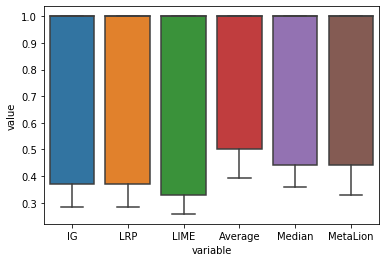

In [55]:
import seaborn as sns
lip_df = pd.DataFrame({'IG':stability['cNN'][0], 'LRP':stability['cNN'][1], 'LIME':stability['cNN'][2], # 'RAND':stability['cNN'][3], 
                        'Average':stability_meta['cNN'][0], 'Median':stability_meta['cNN'][1], 'MetaLion':stability_meta['cNN'][2]})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

In [56]:
lip_df_lnn = pd.DataFrame({'IG':stability['lNN'][1], 'LRP':stability['lNN'][2], 'LIME':stability['lNN'][3], 'RAND':stability['lNN'][4]})
lip_df_nn = pd.DataFrame({'IG':stability['NN'][0], 'LRP':stability['NN'][1], 'LIME':stability['NN'][2], 'RAND':stability['NN'][3]})
lip_df_cnn = pd.DataFrame({'IG':stability['cNN'][0], 'LRP':stability['cNN'][1], 'LIME':stability['cNN'][2], 'RAND':stability['cNN'][3]})

## Measure Consistency!

In [57]:
consistency = {}
for idf,fi_name in enumerate(['IG', 'LRP', 'LIME', 'RAND']):
    all_importance_tests = []
    for neural_name, neural_type in predict_functions.items():

        with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
            importances = json.load(json_file)
        if neural_name == 'lNN':
            all_importance_tests.append(np.array(importances['test'])[:,1:,:])
        else:
            all_importance_tests.append(np.array(importances['test']))
        #meta_explain = MetaExplain(importance_train, feature_names)
    all_importance_tests = np.array(all_importance_tests)
    consistency[fi_name] = gm.consistency(all_importance_tests[:,:,idf,:])
    print(fi_name, np.mean(consistency[fi_name]))

IG 0.39185751014124026
LRP 0.4009673039690312
LIME 0.47351908914599683
RAND 1.0


In [58]:
consistency_meta = {}
for idf, meta_name in enumerate(meta_names):
    all_importance_tests = []
    for neural_name, neural_type in predict_functions.items():
        all_importance_tests.append(np.array(meta_interpretations_test[neural_name]))
    all_importance_tests = np.array(all_importance_tests)
    consistency_meta[meta_name] = gm.consistency(all_importance_tests[:,:,idf,:])
    print(meta_name, np.mean(consistency_meta[meta_name]))

Average 0.5102526794165372
Median 0.4026272834916691
RuleBased 0.3628088695564005


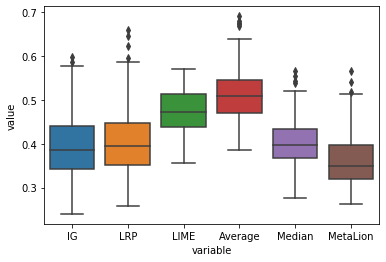

In [59]:
import seaborn as sns
con_df = pd.DataFrame({'IG':consistency['IG'], 'LRP':consistency['LRP'], 'LIME':consistency['LIME'], #'RAND':consistency['RAND'], 
                        'Average':consistency_meta['Average'], 'Median':consistency_meta['Median'], 'MetaLion':consistency_meta['RuleBased']})
sns.boxplot(x="variable", y="value", data=pd.melt(con_df))

In [60]:
import seaborn as sns
con_df_models = pd.DataFrame({'IG':consistency['IG'], 'LRP':consistency['LRP'], 'LIME':consistency['LIME'], 'RAND':consistency['RAND']})
    

## Measuring AUPRC for the meta inXAI technique

In [39]:
from sklearn.compose import ColumnTransformer
pd_x_test = pd.DataFrame(X_test, columns=feature_names)
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=2),pd_x_test.columns)])
auprc = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])

    print('Starting evaluation for', neural_name)
    model_auprc = []
    for idf,fi_name in enumerate(fi_names):
        mean_fi = importance_test[:,idf,:].mean(axis=0)
        model_auprc.append(gm.gradual_perturbation(model=models[neural_name], X=pd_x_test, y=y_test, column_transformer=ct, importances_orig=mean_fi, 
                                        resolution=50,  count_per_step=10, plot=False, task='c'))
    auprc[neural_name] = model_auprc

Starting evaluation for lNN
Starting evaluation for NN
Starting evaluation for cNN


In [40]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    print(neural_name)
    for idf, auprc_score in enumerate(auprc[neural_name]):
        print(fi_names[idf], np.mean(auprc_score))

lNN
Inherent 0.06326359832635982
IG 0.06715481171548116
LRP 0.06478661087866106
LIME 0.05864435146443513
RAND 0.062133891213389074
NN
IG 0.13591631799163184
LRP 0.13662761506276155
LIME 0.13839330543933062
RAND 0.13635146443514648
cNN
IG 0.14191631799163176
LRP 0.1435564853556485
LIME 0.14127196652719662
RAND 0.1411380753138075


In [62]:
from sklearn.metrics import auc

auprc_df_lnn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 50),auprc['lNN'][1])], 'LRP':[auc(np.linspace(0, 1, 50),auprc['lNN'][2])], 'LIME':[auc(np.linspace(0, 1, 50),auprc['lNN'][3])], 'RAND':[auc(np.linspace(0, 1, 50),auprc['lNN'][4])]})
auprc_df_nn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 50),auprc['NN'][0])], 'LRP':[auc(np.linspace(0, 1, 50),auprc['NN'][1])], 'LIME':[auc(np.linspace(0, 1, 50),auprc['NN'][2])], 'RAND':[auc(np.linspace(0, 1, 50),auprc['NN'][3])]})
auprc_df_cnn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 50),auprc['cNN'][0])], 'LRP':[auc(np.linspace(0, 1, 50),auprc['cNN'][1])], 'LIME':[auc(np.linspace(0, 1, 50),auprc['cNN'][2])], 'RAND':[auc(np.linspace(0, 1, 50),auprc['cNN'][3])]})

In [42]:
cons_alpha = 0.2
lip_alpha=20
auc_alpha=0.1

In [47]:
weights = cons_alpha*con_df_models.iloc[33]+lip_alpha*lip_df_lnn.iloc[33]+auc_alpha/auprc_df_lnn
weights

,IG,LRP,LIME,RAND
0,21.574689,21.633009,21.799824,21.802381


In [63]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]

    with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    inxai = []
    for idf, instance in enumerate(X_test):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot(importance_test[idf][1:])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot(importance_test[idf])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot(importance_test[idf])/weights.sum().sum()
        inxai.append(met)
    print('Starting evaluation for', neural_name)
    inxai_stability = gm.stability(pd.DataFrame(X_test), inxai ,epsilon=0.3)
    print('inXAI', np.mean(inxai_stability))

Starting evaluation for lNN
inXAI 0.933781808440685
Starting evaluation for NN
inXAI 0.8029525206358832
Starting evaluation for cNN
inXAI 0.7973275413397637


In [67]:
all_importance_tests = []
for neural_name, neural_type in predict_functions.items():
    with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    if neural_name == 'lNN':
        per_neural = np.array(importances['test'])[:,1:,:]
    else:
        per_neural = np.array(importances['test'])
    
    for idf, instance in enumerate(X_test):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot(per_neural[idf])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot(per_neural[idf])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot(per_neural[idf])/weights.sum().sum()
    all_importance_tests.append(met)
all_importance_tests = np.array(all_importance_tests)
inxai_consistency = gm.consistency(all_importance_tests)
print('inXAI', np.mean(inxai_consistency))

inXAI 0.8894660349182234


## Truthfulness and Complexity evaluation

In [ ]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(importance_train, feature_names)

    print('Starting evaluation for', neural_name)
    for noise in ['weak', 'normal', 'strong']:
        for delta in [0 , 0.0001, 0.001, 0.01, 0.1]:
            my_altruist = Altruist(
                neural_type, X_train, fi_techniques, feature_names, level=noise, delta=delta)
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(X_test)):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(X_test[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                temp_meta = []
                temp_meta.append(meta_explain.meta_avg(b))
                temp_meta.append(meta_explain.meta_median(b))
                temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
                for i in range(len(temp_meta)):
                    cnzw = 0
                    cnzwt = 0
                    for k in temp_meta[i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i+len(importance_test[j])].append(cnzw)
                    nzw_scores_delta[i+len(importance_test[j])].append(cnzwt)
                my_altruist.fis = len(meta_names)
                a = my_altruist.find_untruthful(X_test[j], temp_meta)
                for i in range(len(a[0])):
                    meta_scores[i].append(len(a[0][i]))
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            for meta_score in meta_scores:
                row.append(np.array(meta_score).mean())
            with open('D2_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names+meta_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D2_NZW_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

## Truthfulness and NZW for inXAI

In [93]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    elif neural_name == 'NN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    else:
        fi_techniques = [fi_random]
        fi_names = ['inXAI']

    with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])
    new_test = []
    for idf, instance in enumerate(X_test):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot(importance_test[idf][1:])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot(importance_test[idf])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot(importance_test[idf])/weights.sum().sum()
        new_test.append([met])
    importance_test = np.array(new_test)

    print('Starting evaluation for', neural_name)
    for noise in ['weak', 'normal', 'strong']:
        for delta in [0 , 0.0001, 0.001, 0.01, 0.1]:
            my_altruist = Altruist(
                neural_type, X_train, fi_techniques, feature_names, level=noise, delta=delta)
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(X_test)):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(X_test[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            with open('D2_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D2_NZW_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

(239, 5, 12)
(239, 1, 12)
Starting evaluation for lNN
(239, 4, 12)
(239, 1, 12)
Starting evaluation for NN
(239, 4, 12)
(239, 1, 12)
Starting evaluation for cNN


Example of how to produce $f$ atom type arguments:

In [15]:
my_altruist = Altruist(neural_type, X_train, fi_techniques, feature_names,
                       level=noise, delta=delta, args=True)  # Enable args=True
# After running the find_untruthful method, the last element of the returned elements are the arguments for each interpretation technqiue
a = my_altruist.find_untruthful(X_test[j], importance_test[j])
arguments = a[-1]


Let's explore one argument:

In [16]:
arguments[0][1]  # 0 indicates the interpretation technique, and 1 the feature


['The alteration (INC) did not happen, as the feature value had the max value',
 "$f_{car, DEC}$: The evaluation of the alteration of $car$'s value to $0.9903$ ($DEC$) was performed and the model's behaviour was as expected $Increased$ (0.4386 to 0.4442), according to its importance $z_{car}=-0.63$."]

Ablation study

In [19]:
predict_functions = {'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'NN':
        fi_techniques = [fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(importance_train, feature_names)
    importance_train = np.delete(importance_train, 3, axis=1)
    importance_test = np.delete(importance_test, 3, axis=1)

    print('Starting evaluation for', neural_name)
    for noise in ['normal']:
        for delta in [0.0001]:
            my_altruist = Altruist(neural_type, X_train, fi_techniques,
                                   feature_names, prolog=False, level=noise, delta=delta)
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(X_test)):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(X_test[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                temp_meta = []
                temp_meta.append(meta_explain.meta_avg(b))
                temp_meta.append(meta_explain.meta_median(b))
                temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
                for i in range(len(temp_meta)):
                    cnzw = 0
                    cnzwt = 0
                    for k in temp_meta[i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i+len(importance_test[j])].append(cnzw)
                    nzw_scores_delta[i+len(importance_test[j])].append(cnzwt)
                my_altruist.fis = len(meta_names)
                a = my_altruist.find_untruthful(X_test[j], temp_meta)
                for i in range(len(a[0])):
                    meta_scores[i].append(len(a[0][i]))
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            for meta_score in meta_scores:
                row.append(np.array(meta_score).mean())
            with open('D2_Ablation_Study_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names+meta_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D2_Ablation_Study_NZW_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)


Starting evaluation for NN
Results for: Noise -> normal  Delta -> 0.0001
	 NZW:
Starting evaluation for cNN
Results for: Noise -> normal  Delta -> 0.0001
	 NZW:


In [118]:
predict_functions = {'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'NN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    else:
        fi_techniques = [fi_random]
        fi_names = ['inXAI']

    with open(weights_path+'D2_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])

    fi = 3
    importance_train = np.delete(importance_train, fi, axis=1) #change this manually
    importance_test = np.delete(importance_test, fi, axis=1)
    new_test = []
    for idf, instance in enumerate(X_test):
        if neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.drop(weights.columns[[fi]],axis = 1).dot(importance_test[idf])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.drop(weights.columns[[fi]],axis = 1).dot(importance_test[idf])/weights.sum().sum()
        new_test.append([met])
    importance_test = np.array(new_test)

    print('Starting evaluation for', neural_name)
    for noise in ['normal']:
        for delta in [0.0001]:
            my_altruist = Altruist(
                neural_type, X_train, fi_techniques, feature_names, level=noise, delta=delta)
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(X_test)):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(X_test[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            with open('D2_Ablation_Study_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D2_Ablation_Study_NZW_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

Starting evaluation for NN
Starting evaluation for cNN
